<a href="https://colab.research.google.com/github/ayyanar7/2023/blob/main/binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip --version

pip 25.1.1 from C:\Environments\Deep-learning-environments\Python\Python312\Lib\site-packages\pip (python 3.12)



In [1]:
!python --version

Python 3.12.0


In [14]:
import tqdm

In [15]:
import os
import sys
from collections import Counter

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchinfo
import torchvision
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from tqdm.version import __version__ as tqdm__version__

torch.backends.cudnn.deterministic = True

In [ ]:
import torch

In [16]:
torch.cuda.is_available()

True

In [17]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("CV2 version : ", cv2.__version__)
print("matplotlib version : ", matplotlib.__version__)
print("numpy version : ", np.__version__)
print("torch version : ", torch.__version__)
print("torchinfo version : ", torchinfo.__version__)
print("torchvision version : ", torchvision.__version__)
print("PIL version : ", PIL.__version__)
print("scikit-learn version: ", sklearn.__version__)
print("tqdm version: ", tqdm__version__)

Platform: win32
Python version: 3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:39) [MSC v.1935 64 bit (AMD64)]
---
CV2 version :  4.11.0
matplotlib version :  3.10.3
numpy version :  2.1.2
torch version :  2.7.1+cu126
torchinfo version :  1.8.0
torchvision version :  0.22.1+cu126
PIL version :  11.0.0
scikit-learn version:  1.7.0
tqdm version:  4.67.1


In [18]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cuda device.


In [27]:
data_path_root = "C:\\input-data\\ds-binary-classification"
flowers_dir = os.path.join(data_path_root, "flowers")
birds_dir = os.path.join(data_path_root, "birds")

print("flowers_dir:", flowers_dir)
print("Training Data Directory:", birds_dir)

flowers_dir: C:\input-data\ds-binary-classification\flowers
Training Data Directory: C:\input-data\ds-binary-classification\birds


In [30]:
birds_images = os.listdir(birds_dir)
print("length of birds images: ", len(birds_images))
flowers_images = os.listdir(flowers_dir)
print("length of flowers images: ", len(flowers_images))



length of birds images:  252
length of flowers images:  252


In [32]:
flower_image_name =flowers_images[0]
print(flower_image_name)

flower_image_path = os.path.join(flowers_dir, flower_image_name)
print(flower_image_path)

birds_image_name = birds_images[0]
print(birds_image_name)

birds_image_path = os.path.join(birds_dir, birds_image_name)
print(birds_image_path)

image_00001.jpg
C:\input-data\ds-binary-classification\flowers\image_00001.jpg
train_0001.jpg
C:\input-data\ds-binary-classification\birds\train_0001.jpg


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=591x500 at 0x1A200489D90>


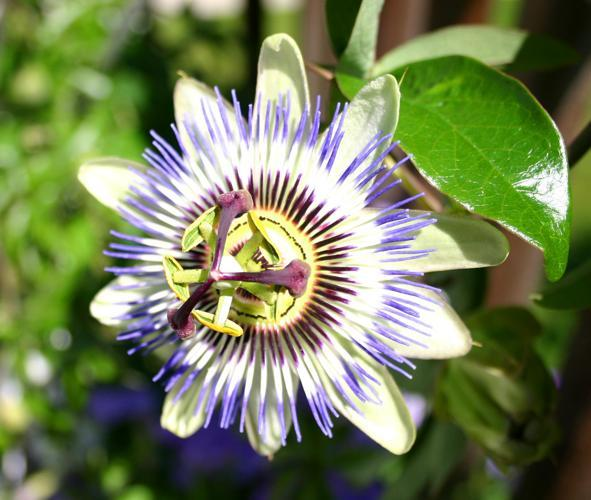

In [36]:
imflower =  Image.open(flower_image_path)
print(imflower)
imflower

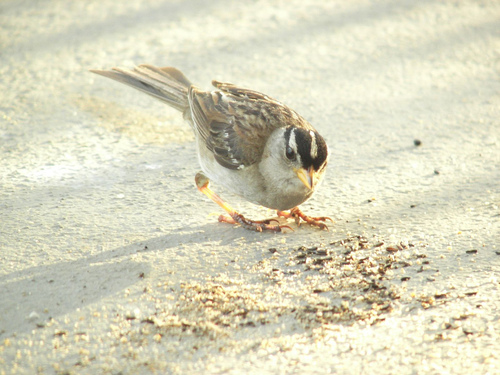

In [37]:
imbird = Image.open(birds_image_path)
imbird

In [43]:
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [44]:
transform = transforms.Compose(
    [
        ConvertToRGB(),  # Convert images to RGB format if not already
        transforms.Resize((224, 224)),  # Resize images to 224x224
        # Convert images to tensors
        transforms.ToTensor()
    ]
)

In [45]:
print(type(transform))
print(transform)

<class 'torchvision.transforms.transforms.Compose'>
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [47]:
ds = datasets.ImageFolder(root=data_path_root, transform=transform)

In [48]:
ds.classes

['birds', 'flowers']

In [53]:
ds

Dataset ImageFolder
    Number of datapoints: 504
    Root location: C:\input-data\ds-binary-classification
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [54]:
im = ds.imgs
print(im[0])

distinct_classes = {x[1] for x in im}
print(distinct_classes)

('C:\\input-data\\ds-binary-classification\\birds\\train_0001.jpg', 0)
{0, 1}


In [56]:
# Important, don't change this!
g = torch.Generator()
g.manual_seed(42)

train_dataset, val_dataset = random_split(ds, [0.8, 0.2], generator=g)

In [57]:
print(f"Length of training set: {len(train_dataset)}")

Length of training set: 404


In [69]:
from tqdm import tqdm

In [70]:
def class_counts(dataset):
    c = Counter(x[1] for x in tqdm(dataset))
    class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})

In [71]:
from ipywidgets import FloatProgress

In [72]:
train_counts = class_counts(train_dataset)
train_counts



  0%|                                                                                          | 0/404 [00:00<?, ?it/s]

  1%|▌                                                                                 | 3/404 [00:00<00:16, 24.87it/s]

  2%|█▍                                                                                | 7/404 [00:00<00:12, 31.87it/s]

  3%|██▍                                                                              | 12/404 [00:00<00:10, 38.42it/s]

  4%|███▍                                                                             | 17/404 [00:00<00:09, 41.63it/s]

  6%|████▌                                                                            | 23/404 [00:00<00:08, 44.64it/s]

  7%|█████▌                                                                           | 28/404 [00:00<00:08, 44.30it/s]

  8%|██████▌                                                                          | 33/404 [00:00<00:08, 45.42it/s]

  9%|███████▌                 

birds      206
flowers    198
dtype: int64

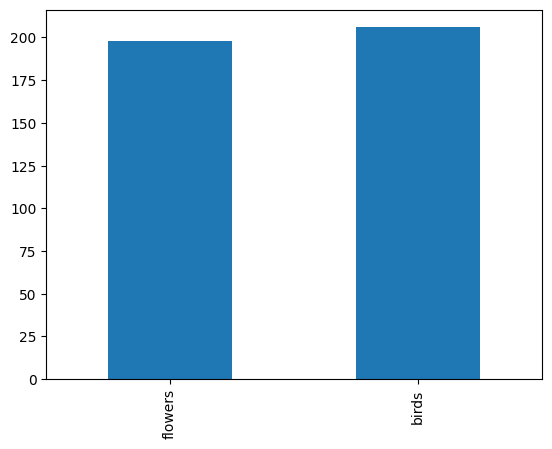

In [73]:
train_counts.sort_values().plot(kind="bar");

In [74]:
val_counts = class_counts(val_dataset)
val_counts



  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

  4%|███▎                                                                              | 4/100 [00:00<00:02, 34.76it/s]

  8%|██████▌                                                                           | 8/100 [00:00<00:02, 32.43it/s]

 13%|██████████▌                                                                      | 13/100 [00:00<00:02, 39.17it/s]

 18%|██████████████▌                                                                  | 18/100 [00:00<00:01, 42.62it/s]

 24%|███████████████████▍                                                             | 24/100 [00:00<00:01, 46.14it/s]

 30%|████████████████████████▎                                                        | 30/100 [00:00<00:01, 48.37it/s]

 36%|█████████████████████████████▏                                                   | 36/100 [00:00<00:01, 48.83it/s]

 41%|█████████████████████████

birds      46
flowers    54
dtype: int64

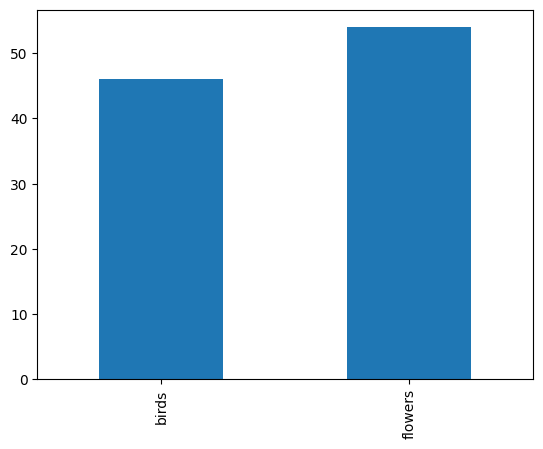

In [75]:
val_counts.sort_values().plot(kind="bar");

In [77]:
# Important, don't change this!
g = torch.Generator()
g.manual_seed(42)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g)

val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False,generator=g)

print(type(val_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [78]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

# This gives you [batch_size, channels, height, width] for images
image_shape = images.shape
print("Shape of batch of images", image_shape)

# This gives you [batch_size] for labels
label_shape = labels.shape
print("Shape of batch of labels:", label_shape)

Shape of batch of images torch.Size([32, 3, 224, 224])
Shape of batch of labels: torch.Size([32])


In [79]:
labels

tensor([1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 1, 0, 1, 1, 0, 1])